In [54]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
%cd "/content/drive/MyDrive/Resume Project/01 Production ML Pipeline with Drift Monitoring, Auto-Retraining & Scalable Deployment"

/content/drive/MyDrive/Resume Project/01 Production ML Pipeline with Drift Monitoring, Auto-Retraining & Scalable Deployment


In [56]:
#Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
#Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [58]:
#importing dependencies
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [59]:
#Loading the dataset
dataset =pd.read_csv("/content/drive/MyDrive/Resume Project/01 Production ML Pipeline with Drift Monitoring, Auto-Retraining & Scalable Deployment/dataset/processed/telcodata_02_processed.csv")

In [60]:
#Copying the data to preventing the accidental overwrites
telco_dataset = dataset.copy()

### Step1) Splitting data as training, testing, and validation data

**splitting the data before applying encoding or embedding techniques so in order to prevent data leakage.**

In [61]:
#Splitting the data as input feature and target data
y= telco_dataset["Churn"]   # Target feature
X = telco_dataset.drop(columns ="Churn")   # Input data point features

In [62]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=7, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [63]:
#Training and testing dataset
print(f"""Shape of training input feautre data : {X_train.shape}""")
print(f"""Shape of training target feautre data : {y_train.shape}""")
print(f"""Shape of testing input feautre data : {X_test.shape}""")
print(f"""Shape of testing target feautre data : {y_test.shape}""")

Shape of training input feautre data : (4500, 18)
Shape of training target feautre data : (4500,)
Shape of testing input feautre data : (1407, 18)
Shape of testing target feautre data : (1407,)


### Step2) Label Encoding for target feature

In [64]:
#Label encoding for Churn columns
le_churn = LabelEncoder()
y_train_encoded = le_churn.fit_transform(y_train)
y_test_encoded = le_churn.transform(y_test)
y_val_encoded = le_churn.transform(y_val)

In [65]:
print(le_churn.classes_)
print(pd.Series(y_train_encoded).value_counts())

['No' 'Yes']
0    3304
1    1196
Name: count, dtype: int64


* No --> 0
* Yes --> 1

### Step3) Creating Preprocessing Pipeline

**OneHot Encoding for train + test dataset categorical columns and standard scaling for numerical columns (For input features only)**

In [66]:
#Separating categorical and numerical columns
categorical_column = X_train.select_dtypes(include = "object").columns
numerical_column = X_test.select_dtypes(exclude= "object").columns

In [67]:
# Creating Transformer for performing scaling and encoding
transformer_instance = ColumnTransformer(
    [
        ("scaler", StandardScaler(), numerical_column),
        ("oh_encoder", OneHotEncoder(handle_unknown="ignore"), categorical_column)
    ]
)

### Step4) Creating a function for metrics evaluation and Roc-auc curve plotting

In [68]:
def eval_metrics(true, pred, prob,  dataset_type):
  acc = accuracy_score(true, pred)
  recall = recall_score(true, pred)
  f1 = f1_score(true, pred)
  prec = precision_score(true, pred)
  roc_auc = roc_auc_score(true, prob)
  report= classification_report(true, pred)

  print(f"Accuracy score for {dataset_type} is : {acc}")
  print(f"Recall score for {dataset_type} is : {recall}")
  print(f"f1 score for {dataset_type} is : {f1}")
  print(f"Precision score for {dataset_type} is : {prec}")
  if prob is not None:
    print(f"Roc-auc score for {dataset_type} is : {roc_auc}")
  print(f"Classification report for {dataset_type} is : \n {report}")
  print("\n")
  print("==" * 50)
  print("\n")




In [69]:
def roc_auc_curve(y_true, y_prob, dataset_type):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {dataset_type}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

### Step 5 **Main Step** Pipeline creation for different models

In [70]:
# evaluation strategy (since Churn is imbalanced , stratification is required)
cv= StratifiedKFold(n_splits=5, shuffle= True, random_state = 42)

In [71]:
# Define models and param
model = {
    "logistic_regression" : LogisticRegression(),
    "Naive_bayes" : BernoulliNB(),
    "rf_classifier" : RandomForestClassifier(),
    "xg_classifier": XGBClassifier(),
    "MLP" : MLPClassifier()
}

param = {
    "logistic_regression": {
        "model__C": [0.01, 0.1, 1, 10, 100],            # Inverse of regularization strength
        "model__penalty": ["l2"],                       # Regularization norm
        "model__solver": ["lbfgs", "liblinear"],        # Algorithm to use in optimization
        "model__class_weight" : ["balanced"]
    },

    "Naive_bayes": {
        "model__alpha": [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], # Additive (Laplace/Lidstone) smoothing parameter
    },

    "rf_classifier": {
        "model__n_estimators": [50, 100, 200],          # Number of trees in the forest
        "model__max_depth": [None, 5, 8 , 10],         # Maximum depth of the tree
        "model__min_samples_split": [2, 5, 10],         # Min samples required to split an internal node
        "model__min_samples_leaf": [5, 10],            # Min samples required to be at a leaf node
        "model__class_weight": ["balanced"]
    },

    "xg_classifier": {
        "model__n_estimators": [50, 100, 200],          # Number of boosting rounds
        "model__learning_rate": [0.01, 0.1, 0.2],       # Step size shrinkage (eta)
        "model__max_depth": [3, 5, 7],                  # Maximum depth of a tree
        "model__subsample": [0.8, 1.0],                 # Subsample ratio of the training instances
        "model__colsample_bytree": [0.8, 1.0]           # Subsample ratio of columns when constructing each tree
    },

    "MLP": {
        "model__hidden_layer_sizes": [(50,), (100,), (50, 50)], # Size of hidden layers
        "model__activation": ["tanh", "relu"],                  # Activation function
        "model__solver": ["adam", "sgd"],                       # The solver for weight optimization
        "model__alpha": [0.0001, 0.05],                         # L2 penalty (regularization term)
        "model__learning_rate": ["constant", "adaptive"]        # Learning rate schedule
    }
}

In [72]:
#Training models
trained_models= {}
results = {}

for model_name, model_instance in model.items():

  print(f"\n 🦚 Training model : {model_name}")
  print("=" * 80)

  pipeline = Pipeline(
    steps = [
        ("preprocessor", transformer_instance),
        ("model", model_instance)
    ]
  )

  #Grid Search
  grid =GridSearchCV(
      estimator = pipeline,
      param_grid = param[model_name],
      scoring = "roc_auc",
      n_jobs = -1,
      cv = cv,
      verbose=True,
  )

  grid.fit(X_train , y_train_encoded)
  best_model = grid.best_estimator_
  trained_models[model_name] = best_model
  print(f"Best Params for {model_name}: \n {grid.best_params_} \n with score of {grid.best_score_}")

  #Training Evaluation
  y_train_pred = best_model.predict(X_train)
  y_train_prob = best_model.predict_proba(X_train)[:, 1]

  eval_metrics(y_train_encoded, y_train_pred, y_train_prob, dataset_type=f"{model_name} - Training Data")

  #Test Evaluation
  y_test_pred = best_model.predict(X_test)
  y_test_prob = best_model.predict_proba(X_test)[:, 1]

  eval_metrics(y_test_encoded, y_test_pred, y_test_prob, dataset_type = f"{model_name} - Testing Data")

  #Store the results
  results[model_name] = {
        "best_params": grid.best_params_,
        "train_roc_auc": roc_auc_score(y_train_encoded, y_train_prob),
        "train_recall" : recall_score(y_train_encoded, y_train_pred),
        "test_roc_auc": roc_auc_score(y_test_encoded, y_test_prob),
        "test_recall": recall_score(y_test_encoded, y_test_pred)
  }




 🦚 Training model : logistic_regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for logistic_regression: 
 {'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'} 
 with score of 0.8432184661450656
Accuracy score for logistic_regression - Training Data is : 0.7428888888888889
Recall score for logistic_regression - Training Data is : 0.8060200668896321
f1 score for logistic_regression - Training Data is : 0.6249594813614262
Precision score for logistic_regression - Training Data is : 0.5103229221810481
Roc-auc score for logistic_regression - Training Data is : 0.8472081069262352
Classification report for logistic_regression - Training Data is : 
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      3304
           1       0.51      0.81      0.62      1196

    accuracy                           0.74      4500
   macro avg       0.71      0.76      0.71  

In [73]:
#Converting result to dataframe for better visualization
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("test_roc_auc", ascending=False)
results_df


,best_params,train_roc_auc,train_recall,test_roc_auc,test_recall
xg_classifier,"{'model__colsample_bytree': 1.0, 'model__learn...",0.866542,0.54097,0.861425,0.580214
rf_classifier,"{'model__class_weight': 'balanced', 'model__ma...",0.885754,0.834448,0.85986,0.802139
MLP,"{'model__activation': 'tanh', 'model__alpha': ...",0.846677,0.54097,0.854892,0.564171
logistic_regression,"{'model__C': 1, 'model__class_weight': 'balanc...",0.847208,0.80602,0.854348,0.815508
Naive_bayes,{'model__alpha': 10.0},0.818795,0.803512,0.82877,0.820856


### INTERPRETATION --> Logistic regression is performing quite well while random forest is seem to be little overfitting

In [87]:
# Best Params for best models
best_params = results_df.loc["logistic_regression"].best_params

In [88]:
#Model Training
log_reg_pipeline = Pipeline(
    steps = [
        ("preprocessor", transformer_instance),
        ("logistic Regression", LogisticRegression(C=100, class_weight = "balanced", penalty = "l2", solver="lbfgs"))
    ]
)

log_reg_pipeline.fit(X_train , y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('oh_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('logistic Regression',
                 LogisticRegression(C=100, class_weight='balanced'))])

In [89]:
## Predicting scores by logistic regression
y_train_pred = log_reg_pipeline.predict(X_train)
y_train_prob = log_reg_pipeline.predict_proba(X_train)[:, 1]

y_test_pred = log_reg_pipeline.predict(X_test)
y_test_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]

y_val_pred = log_reg_pipeline.predict(X_val)
y_val_prob = log_reg_pipeline.predict_proba(X_val)[:, 1]



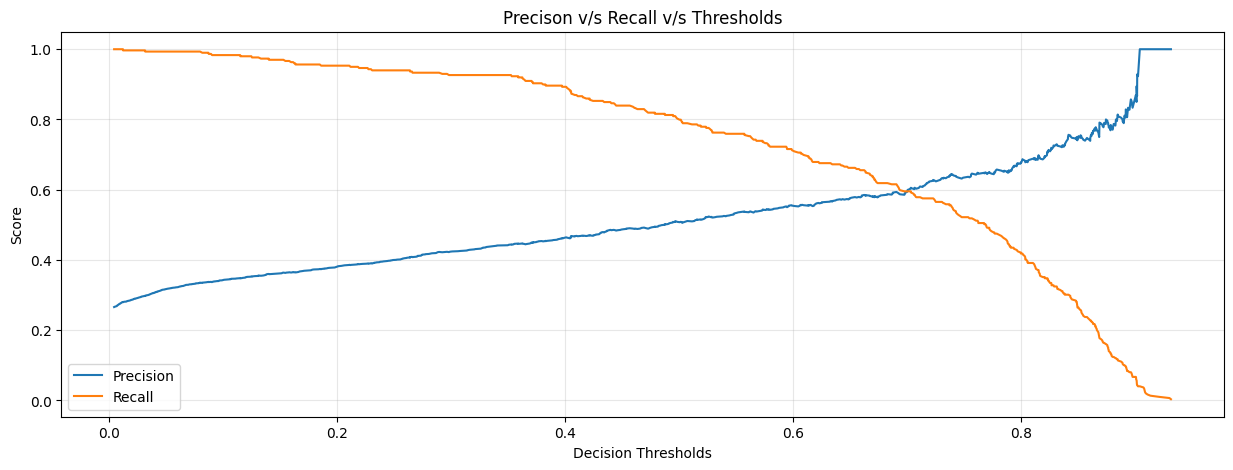

In [90]:
#Precision Recall Curve
precision, recall , thresholds = precision_recall_curve(y_val_encoded, y_val_prob)

#Plotting Precision vs Recall Curve

plt.figure(figsize=(15, 5))
plt.plot(thresholds, precision[:-1], label= "Precision")
plt.plot(thresholds, recall[:-1], label= "Recall")

plt.xlabel("Decision Thresholds")
plt.ylabel("Score")
plt.title("Precison v/s Recall v/s Thresholds")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [93]:
# Validation probabilities
y_val_prob = log_reg_pipeline.predict_proba(X_val)[:, 1]

# Apply custom threshold
threshold = 0.35
y_val_pred_custom = (y_val_prob >= threshold).astype(int)

print("Recall:", recall_score(y_val_encoded, y_val_pred_custom))
print("Precision:", precision_score(y_val_encoded, y_val_pred_custom))
print("ROC-AUC:", roc_auc_score(y_val_encoded, y_val_prob))


Recall: 0.9264214046822743
Precision: 0.4424920127795527
ROC-AUC: 0.8387441593042183


In [97]:
#Final Evaluation
y_test_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_test_pred_final = (y_test_prob >= 0.35).astype(int)

print("Final Test Recall:", recall_score(y_test_encoded, y_test_pred_final))
print("Final Test Precision:", precision_score(y_test_encoded, y_test_pred_final))
print("Final Test ROC-AUC:", roc_auc_score(y_test_encoded, y_test_prob))


Final Test Recall: 0.9278074866310161
Final Test Precision: 0.44601542416452444
Final Test ROC-AUC: 0.8540658276863504


## Final Threshold Selection

A decision threshold of 0.35 was selected based on validation data to prioritize recall.
This achieved approximately 93% recall on both validation and test sets, ensuring most churners are identified.
Although precision decreased as expected, this trade-off is acceptable given the higher cost of false negatives in churn prediction.
